## Python for Finance 7 - Investment Portfolio Management

In [1]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data as web # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
import mplfinance as mpf # Matplotlib finance

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

#Statsmodels is a great library we can use to run regressions.
import statsmodels.api as sm
# Seaborn extends the capabilities of Matplotlib
import seaborn as sns
# Used for calculating regressions
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

#### Dates & Other Constants

In [2]:
# Define path to files
PATH = "../data/stock-list/"

# Start date defaults
ST_YEAR = 2017
ST_MONTH = 1
ST_DAY = 1
ST_DATE_STR = f"{ST_YEAR}-{ST_MONTH}-{ST_DAY}"
ST_DATE_DATETIME = dt.datetime(ST_YEAR, ST_MONTH, ST_DAY)

# End date defaults
EN_YEAR = 2021
EN_MONTH = 12
EN_DAY = 31
EN_DATE_STR = f"{EN_YEAR}-{EN_MONTH}-{EN_DAY}"
EN_DATE_DATETIME = dt.datetime(EN_YEAR, EN_MONTH, EN_DAY)

risk_free_rate = 0.0125 # Approximate 10 year bond rate

#### Get Stock File Names in a List

In [3]:
files = [x for x in listdir(PATH) if isfile(join(PATH, x))]
tickers = [os.path.splitext(x)[0] for x in files]
tickers

tickers.sort()
len(tickers)

2888

#### Function that Returns a Dataframe from a CSV

In [4]:
def get_df_from_csv(ticker):
    try:
        df = pd.read_csv(PATH + ticker + '.csv', index_col='Date', 
                         parse_dates=True)
    except FileNotFoundError:
        pass
        # print("File Doesn't Exist")
    else:
        return df

#### Merge Multiple Stocks in One Dataframe by Column Name

In [5]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv(x)
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

#### Markowitz Portfolio Optimization

Harry Markowitz proved that you could make what is called an efficient portfolio. That is a portfolio that optimizes return while also minimizing risk. We don't benefit from analyzing individual securities at the same rate as if we instead considered a portfolio of stocks.

We do this by creating portfolios with stocks that are not correlated. We want to calculate expected returns by analyzing the returns of each stock multiplied by its weight.

$w_1r_1 + w_2r_2 = r_p$

The standard deviation of the portfolio is found this way. Sum multiple calculations starting by finding the product of the first securities weight squared times its standard deviation squared. The middle is 2 times the correlation coefficient between the stocks. And, finally add those to the weight squared times the standard deviation squared for the second security.

$(w_1 \sigma_1 + w_2 \sigma_2)^2 = w_1^2 \sigma_1^2 + 2w_1 \sigma_1w_2 \sigma_2 \rho_1 + w_2^2 \sigma_2^2$

#### Plotting an Efficient Frontier

#### Stock Portfolio

In [6]:
# I used the calculations made in part 4 of this course to pick the best performing
# stocks in the main sectors in the year 2018 through 2019
# I made slight changes in those situations that allowed me to pick companies I knew
port_list = ["GNRC", "DXCM", "AMD", "NFLX", "COST", "TGT", "AES", "MSCI", 
             "NEM", "AMT", "HES"]

#### Merge all Stock Price Data

In [7]:
mult_df = merge_df_by_column_name('Adj Close',  '2018-01-01', 
                                  '2021-09-01', *port_list)
mult_df

,GNRC,DXCM,AMD,NFLX,COST,TGT,AES,MSCI,NEM,AMT,HES
Date,,,,,,,,,,,
2018-01-02,48.029999,57.990002,10.980000,201.070007,177.262619,61.060032,9.477119,122.557182,33.934792,129.876083,44.593990
2018-01-03,49.730000,58.080002,11.550000,205.050003,179.389923,60.644718,9.468409,124.419357,33.650219,130.382217,46.038528
2018-01-04,50.070000,52.250000,12.120000,205.630005,177.996857,59.452950,9.433569,126.377502,34.023708,128.477310,47.147549
2018-01-05,50.410000,53.259998,11.880000,209.990005,176.726089,60.084953,9.468409,127.692543,34.148216,129.305542,48.610722
2018-01-08,49.529999,55.439999,12.280000,212.050003,177.413223,60.653748,9.468409,127.865318,34.112644,130.685913,48.918274
...,...,...,...,...,...,...,...,...,...,...,...
2021-08-26,427.470001,517.059998,107.269997,550.119995,449.309998,247.041718,23.557798,621.724243,55.548443,280.472321,66.946075
2021-08-27,437.109985,520.710022,111.400002,558.919983,450.339996,247.260010,23.873611,627.384399,57.078644,282.770142,69.379578
2021-08-30,442.700012,521.539978,111.320000,566.179993,455.929993,247.438629,23.784790,636.193420,56.411633,288.891022,68.614761


#### Plot Growth of Investment over Total Dataset

<AxesSubplot:xlabel='Date'>

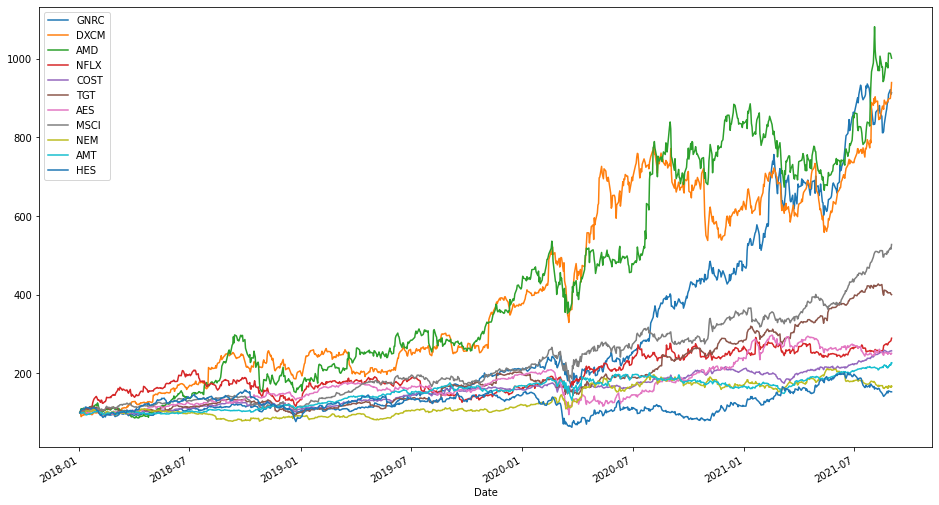

In [8]:
(mult_df / mult_df.iloc[0] * 100).plot(figsize=(16, 9))

#### Mean Returns

In [9]:
returns = np.log(mult_df / mult_df.shift(1))
mean_ret = returns.mean() * 252 # 252 average trading days per year
mean_ret

GNRC    0.592377
DXCM    0.599971
AMD     0.617096
NFLX    0.284655
COST    0.253339
TGT     0.371504
AES     0.246643
MSCI    0.445531
NEM     0.137823
AMT     0.219803
HES     0.114349
dtype: float64

#### Covariance

In [10]:
returns.cov() * 252

,GNRC,DXCM,AMD,NFLX,COST,TGT,AES,MSCI,NEM,AMT,HES
GNRC,0.161022,0.061192,0.088647,0.054029,0.035046,0.039514,0.063987,0.069551,0.026633,0.042809,0.083510
DXCM,0.061192,0.232575,0.092524,0.064887,0.028646,0.028975,0.042948,0.080897,0.021175,0.037130,0.058218
AMD,0.088647,0.092524,0.309445,0.102345,0.046085,0.056026,0.054222,0.094588,0.036432,0.040833,0.084819
NFLX,0.054029,0.064887,0.102345,0.168817,0.037780,0.029738,0.031379,0.064767,0.015098,0.031431,0.044727
COST,0.035046,0.028646,0.046085,0.037780,0.047877,0.033458,0.025177,0.035866,0.012733,0.029809,0.024043
TGT,0.039514,0.028975,0.056026,0.029738,0.033458,0.096508,0.037942,0.033371,0.008862,0.027632,0.039134
AES,0.063987,0.042948,0.054222,0.031379,0.025177,0.037942,0.141715,0.060962,0.021594,0.041295,0.091763
MSCI,0.069551,0.080897,0.094588,0.064767,0.035866,0.033371,0.060962,0.121341,0.026459,0.047421,0.070272
NEM,0.026633,0.021175,0.036432,0.015098,0.012733,0.008862,0.021594,0.026459,0.106236,0.020592,0.031115
AMT,0.042809,0.037130,0.040833,0.031431,0.029809,0.027632,0.041295,0.047421,0.020592,0.079985,0.037551


#### Correlation

In [11]:
returns.corr()

,GNRC,DXCM,AMD,NFLX,COST,TGT,AES,MSCI,NEM,AMT,HES
GNRC,1.000000,0.316207,0.397130,0.327698,0.399146,0.316974,0.423589,0.497574,0.203634,0.377215,0.383940
DXCM,0.316207,1.000000,0.344890,0.327469,0.271473,0.193401,0.236569,0.481555,0.134710,0.272235,0.222715
AMD,0.397130,0.344890,1.000000,0.447780,0.378625,0.324201,0.258926,0.488136,0.200934,0.259543,0.281299
NFLX,0.327698,0.327469,0.447780,1.000000,0.420232,0.232980,0.202871,0.452525,0.112737,0.270482,0.200830
COST,0.399146,0.271473,0.378625,0.420232,1.000000,0.492218,0.305652,0.470567,0.178534,0.481709,0.202721
TGT,0.316974,0.193401,0.324201,0.232980,0.492218,1.000000,0.324442,0.308378,0.087523,0.314508,0.232405
AES,0.423589,0.236569,0.258926,0.202871,0.305652,0.324442,1.000000,0.464892,0.175989,0.387868,0.449705
MSCI,0.497574,0.481555,0.488136,0.452525,0.470567,0.308378,0.464892,1.000000,0.233041,0.481351,0.372177
NEM,0.203634,0.134710,0.200934,0.112737,0.178534,0.087523,0.175989,0.233041,1.000000,0.223391,0.176116
AMT,0.377215,0.272235,0.259543,0.270482,0.481709,0.314508,0.387868,0.481351,0.223391,1.000000,0.244955


#### Generate Random Weight Equal to 1

In [12]:
# Generate 11 random values that sum to 1
weights = np.random.random(11)
weights /= np.sum(weights)
print('Weights :', weights)
print('Total Weight :', np.sum(weights))

Weights : [0.06282529 0.02161078 0.106755   0.04178345 0.0354946  0.13120322
 0.12557622 0.12609116 0.12004537 0.18513345 0.04348145]
Total Weight : 1.0


#### Calculating Return of Portfolio

In [13]:
# Provide return of portfolio using random weights over the whole dataset
np.sum(weights * returns.mean()) * 252

0.33504851958111165

#### Calculating Volatility

In [14]:
np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))

0.23030229829869747

#### Analyzing Returns & Risk of 10000 Combinations

In [15]:
p_ret = [] # Returns list
p_vol = [] # Volatility list
p_SR = [] # Sharpe Ratio list
p_wt = [] # Stock weights list


for x in range(10000):
    # Generate random weights
    p_weights = np.random.random(11)
    p_weights /= np.sum(p_weights)
    
    # Add return using those weights to list
    ret_1 = np.sum(p_weights * returns.mean()) * 252
    p_ret.append(ret_1)
    
    # Add volatility or standard deviation to list
    vol_1 = np.sqrt(np.dot(p_weights.T, np.dot(returns.cov() * 252, p_weights)))
    p_vol.append(vol_1)
    
    # Get Sharpe ratio
    SR_1 = (ret_1 - risk_free_rate) / vol_1
    p_SR.append(SR_1)
    
    # Store the weights for each portfolio
    p_wt.append(p_weights)
    
# Convert to Numpy arrays
p_ret = np.array(p_ret)
p_vol = np.array(p_vol)
p_SR = np.array(p_SR)
p_wt = np.array(p_wt)

p_ret, p_vol, p_SR, p_wt

(array([0.28363274, 0.37370971, 0.35010626, ..., 0.35195588, 0.38227273,
        0.30536681]),
 array([0.23376798, 0.26123521, 0.26583071, ..., 0.24888558, 0.24445736,
        0.22551313]),
 array([1.15983696, 1.3826992 , 1.27000474, ..., 1.36390334, 1.5126267 ,
        1.29866856]),
 array([[0.08685221, 0.05606859, 0.02126319, ..., 0.10032027, 0.18083544,
         0.17295763],
        [0.02100816, 0.08276194, 0.18052159, ..., 0.01421693, 0.05035534,
         0.10377973],
        [0.09997581, 0.1196885 , 0.01530502, ..., 0.01103464, 0.05796793,
         0.14032139],
        ...,
        [0.13683386, 0.13788944, 0.03268454, ..., 0.12046952, 0.07818302,
         0.15411301],
        [0.04667454, 0.14009202, 0.12216844, ..., 0.13654868, 0.03172567,
         0.06129402],
        [0.06773047, 0.05627165, 0.05802719, ..., 0.09483072, 0.09552448,
         0.08227185]]))

#### Plotting the Efficient Frontier

<AxesSubplot:xlabel='Volatility', ylabel='Return'>

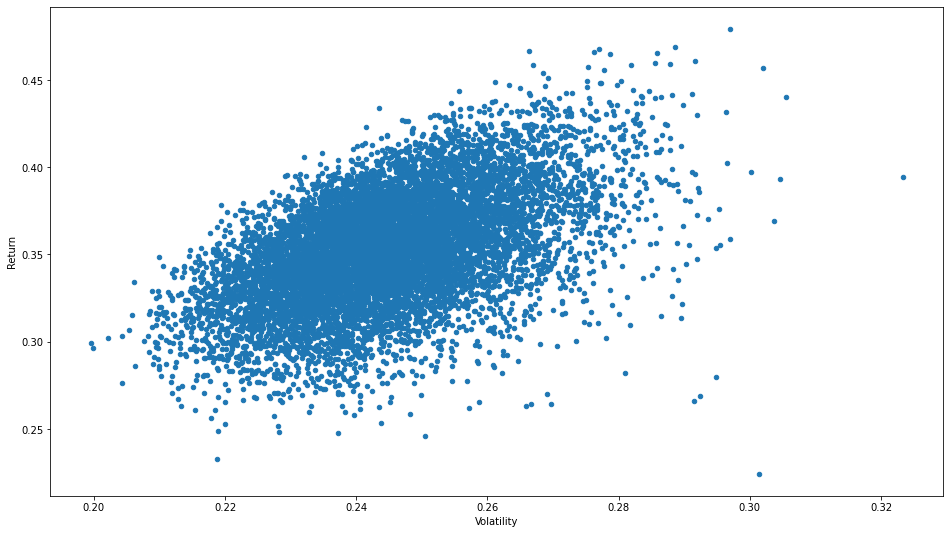

In [16]:
# Create a dataframe with returns and volatility
ports = pd.DataFrame({'Return': p_ret, 'Volatility': p_vol})

ports.plot(x='Volatility', y='Return', kind='scatter', figsize=(16, 9))

#### Sharpe Ratio

People want to maximize returns while avoiding as much risk as possible. William Sharpe created the Sharpe Ratio to find the portfolio that provides the best return for the lowest amount of risk.

*Sharpe Ratio* = $ \frac{r_i - r_f}{\sigma_i}$

$r_f = $ Risk Free Rate

$r_i = $ Rate of Return of the stock

$\sigma_i = $ Standard Deviation of the Stock

As return increases so does the Sharpe Ratio, but as Standard Deviation increase the Sharpe Ratio decreases.

In [17]:
# Return the index of the largest Sharpe Ratio
SR_idx = np.argmax(p_SR)

# Find the ideal portfolio weighting at that index
i = 0
while i < 11:
    print("Stock : %s : %2.2f" % (port_list[i], (p_wt[4296][i] * 100)))
    i += 1
    
# Find volatility of that portfolio
print("\nVolatility :", p_vol[4296])
      
# Find return of that portfolio
print("Return :", p_ret[4296])

Stock : GNRC : 5.25
Stock : DXCM : 7.41
Stock : AMD : 3.42
Stock : NFLX : 5.14
Stock : COST : 11.04
Stock : TGT : 15.10
Stock : AES : 6.97
Stock : MSCI : 14.36
Stock : NEM : 12.91
Stock : AMT : 14.49
Stock : HES : 3.90

Volatility : 0.21482078237309024
Return : 0.330652471174451
